In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy

In [2]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [3]:
def make_K_list(X_list, n_nodes):
    """
    Computes the kernel matrices of the variables in X_array, where each column represents one variable.
    Returns a list of the kernel matrices of each variable.
    """
    k_list = list(pairwise_kernels(X_list[i], metric='rbf', gamma=0.5/(width(X_list[i])**2)) for i in range(n_nodes))
    return k_list

In [4]:
def dHSIC(k_list):
    """
    Computes the dHSIC statistic
    """
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    term1, term2, term3 = 1, 1, 2/n_samples    
    for j in range(n_nodes):
        term1 = term1 * k_list[j]
        term2 = term2 * np.sum(k_list[j]) / (n_samples**2)
        term3 = term3 * np.sum(k_list[j], axis=0) / n_samples
    term1_sum = np.sum(term1)
    term3_sum = np.sum(term3)
    dHSIC = term1_sum/(n_samples**2) + term2 - term3_sum
    return dHSIC

In [124]:
mean = [0,0,0]

dHSIC_cor = []
g_corr = []
for s in np.linspace(0,1,201):
    cov = [[1,s,s],[s,1,s],[s,s,1]]
    x1,x2,x3 = np.random.multivariate_normal(mean, cov, 4000).T
    K1 = pairwise_kernels(x1.reshape(-1, 1), metric='rbf', gamma=0.5/(width(x1.reshape(-1, 1))**2))
    K2 = pairwise_kernels(x2.reshape(-1, 1), metric='rbf', gamma=0.5/(width(x2.reshape(-1, 1))**2))
    K3 = pairwise_kernels(x3.reshape(-1, 1), metric='rbf', gamma=0.5/(width(x3.reshape(-1, 1))**2))
    
    K_list_all = [K1,K2,K3]
    K_list_1 = [K1,K1,K1]
    K_list_2 = [K2,K2,K2]
    K_list_3 = [K3,K3,K3]
    
    dHSIC_all = dHSIC(K_list_all)
    dHSIC_1 = dHSIC(K_list_1)
    dHSIC_2 = dHSIC(K_list_2)
    dHSIC_3 = dHSIC(K_list_3)
    
    dHSIC_cor.append(dHSIC_all/(dHSIC_1*dHSIC_2*dHSIC_3)**(1/3)) 
    
    cov3 = np.cov(np.array([x1,x2,x3]))
    g_corr.append(np.sqrt(1 -np.linalg.det(cov3)/(np.diag(cov3)[0]*np.diag(cov3)[1]*np.diag(cov3)[2])))

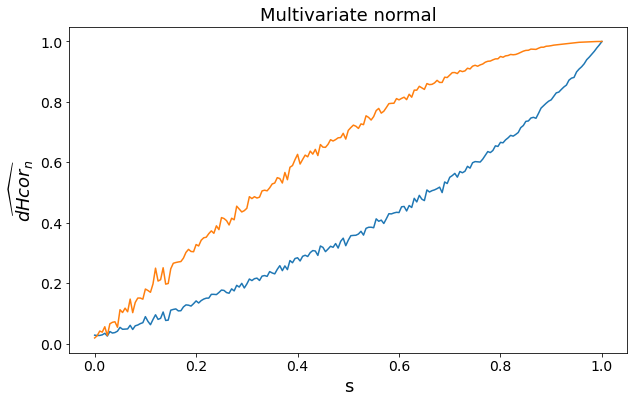

In [154]:
fig, ax = plt.subplots( figsize=(10, 6))
ax.plot(np.linspace(0,1,201), np.sqrt(dHSIC_cor))
ax.plot(np.linspace(0,1,201), g_corr)
ax.set_title("Multivariate normal", fontdict={'fontsize': 18})
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('s', fontdict={'fontsize': 18})
ax.set_ylabel(r'$\widehat{dHcor}_n$', fontdict={'fontsize': 18})
#plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/norm_ex1.png', format='png', bbox_inches='tight')
plt.show()

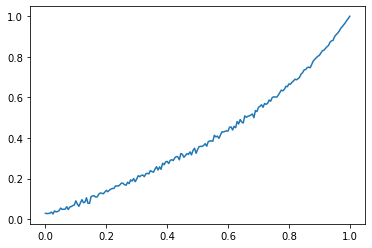

In [126]:
plt.plot(np.linspace(0,1,201), np.sqrt(dHSIC_cor))
plt.show()

In [128]:
mean = [0,0,0,0]
cov = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]

dHSIC_cor2 = []
g_corr2 = []
for s in np.linspace(0,1,201):
    
    x,x1,x2,x3 = np.random.multivariate_normal(mean, cov,4000).T
    
    y1,y2,y3 = s*x+(1-s)*x1, s*x+(1-s)*x2, s*x+(1-s)*x3
    
    K1 = pairwise_kernels(y1.reshape(-1, 1), metric='rbf', gamma=0.5/(width(y1.reshape(-1, 1))**2))
    K2 = pairwise_kernels(y2.reshape(-1, 1), metric='rbf', gamma=0.5/(width(y2.reshape(-1, 1))**2))
    K3 = pairwise_kernels(y3.reshape(-1, 1), metric='rbf', gamma=0.5/(width(y3.reshape(-1, 1))**2))
    
    K_list_all = [K1,K2,K3]
    K_list_1 = [K1,K1,K1]
    K_list_2 = [K2,K2,K2]
    K_list_3 = [K3,K3,K3]
    
    dHSIC_all = dHSIC(K_list_all)
    dHSIC_1 = dHSIC(K_list_1)
    dHSIC_2 = dHSIC(K_list_2)
    dHSIC_3 = dHSIC(K_list_3)
    
    dHSIC_cor2.append(dHSIC_all/(dHSIC_1*dHSIC_2*dHSIC_3)**(1/3)) 
    
    cov3 = np.cov(np.array([y1,y2,y3]))
    g_corr2.append(np.sqrt(1 -np.linalg.det(cov3)/(np.diag(cov3)[0]*np.diag(cov3)[1]*np.diag(cov3)[2])))

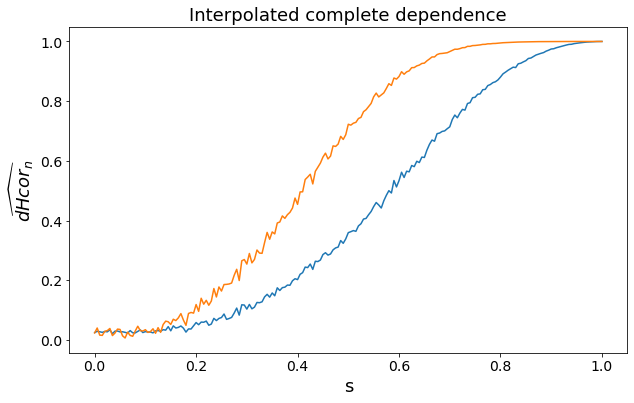

In [130]:
fig, ax = plt.subplots( figsize=(10, 6))
ax.plot(np.linspace(0,1,201),np.sqrt(dHSIC_cor2))
ax.plot(np.linspace(0,1,201), g_corr2)
ax.set_title("Interpolated complete dependence", fontdict={'fontsize': 18})
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('s', fontdict={'fontsize': 18})
ax.set_ylabel(r'$\widehat{dHcor}_n$', fontdict={'fontsize': 18})
#plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/norm_ex2.png', format='png', bbox_inches='tight')
plt.show()

In [131]:
mean = [0,0,0]
cov = [[1,0,0],[0,1,0],[0,0,1]]

dHSIC_cor3 = []
g_corr3 = []
for s in np.linspace(0,1,201):
    
    x1,x2,x3 = np.random.multivariate_normal(mean, cov,4000).T
    
    y1 = np.random.binomial(n=1,p=0.5,size=4000)
    y2 = np.random.binomial(n=1,p=0.5,size=4000)
    y3 = np.asarray([int(y1[i]==y2[i]) for i in range(len(y1))])
    
    z1,z2,z3 = y1+(1-s)*x1, y2+(1-s)*x2, y3+(1-s)*x3
    
    K1 = pairwise_kernels(z1.reshape(-1, 1), metric='rbf', gamma=0.5/(width(z1.reshape(-1, 1))**2))
    K2 = pairwise_kernels(z2.reshape(-1, 1), metric='rbf', gamma=0.5/(width(z2.reshape(-1, 1))**2))
    K3 = pairwise_kernels(z3.reshape(-1, 1), metric='rbf', gamma=0.5/(width(z3.reshape(-1, 1))**2))
    
    K_list_all = [K1,K2,K3]
    K_list_1 = [K1,K1,K1]
    K_list_2 = [K2,K2,K2]
    K_list_3 = [K3,K3,K3]
    
    dHSIC_all = dHSIC(K_list_all)
    dHSIC_1 = dHSIC(K_list_1)
    dHSIC_2 = dHSIC(K_list_2)
    dHSIC_3 = dHSIC(K_list_3)
    
    dHSIC_cor3.append(dHSIC_all/(dHSIC_1*dHSIC_2*dHSIC_3)**(1/3)) 
    cov3 = np.cov(np.array([z1,z2,z3]))
    g_corr3.append(np.sqrt(1 -np.linalg.det(cov3)/(np.diag(cov3)[0]*np.diag(cov3)[1]*np.diag(cov3)[2])))

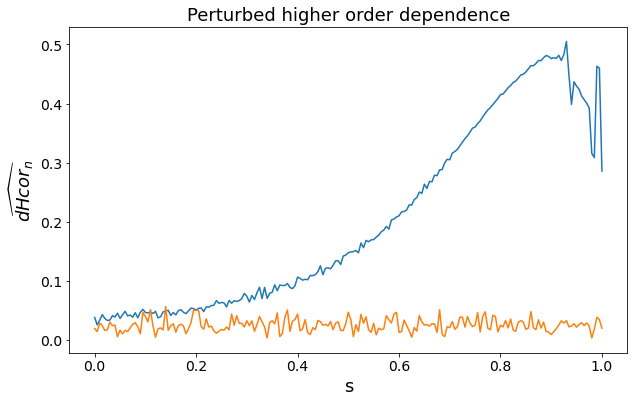

In [132]:
fig, ax = plt.subplots( figsize=(10, 6))
ax.plot(np.linspace(0,1,201), np.sqrt(dHSIC_cor3))
ax.plot(np.linspace(0,1,201), g_corr3)
ax.set_title("Perturbed higher order dependence", fontdict={'fontsize': 18})
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('s', fontdict={'fontsize': 18})
ax.set_ylabel(r'$\widehat{dHcor}_n$', fontdict={'fontsize': 18})
#plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/norm_ex3.png', format='png', bbox_inches='tight')
plt.show()

In [196]:
mean = [0,0,0]
cov = [[1,0,0],[0,1,0],[0,0,1]]

dHSIC_cor3s = []
g_corr3s = []
for s in np.linspace(0,1,100):
    
    x1,x2,x3 = np.random.multivariate_normal(mean, cov,200).T
    
    y1 = np.random.binomial(n=1,p=0.5,size=200)
    y2 = np.random.binomial(n=1,p=0.5,size=200)
    y3 = np.asarray([int(y1[i]==y2[i]) for i in range(len(y1))])
    
    z1,z2,z3 = s*y1+(1-s)*x1, s*y2+(1-s)*x2, s*y3+(1-s)*x3
    
    K1 = pairwise_kernels(z1.reshape(-1, 1), metric='rbf', gamma=0.5/(width(z1.reshape(-1, 1))**2))
    K2 = pairwise_kernels(z2.reshape(-1, 1), metric='rbf', gamma=0.5/(width(z2.reshape(-1, 1))**2))
    K3 = pairwise_kernels(z3.reshape(-1, 1), metric='rbf', gamma=0.5/(width(z3.reshape(-1, 1))**2))
    
    K_list_all = [K1,K2,K3]
    K_list_1 = [K1,K1,K1]
    K_list_2 = [K2,K2,K2]
    K_list_3 = [K3,K3,K3]
    
    dHSIC_all = dHSIC(K_list_all)
    dHSIC_1 = dHSIC(K_list_1)
    dHSIC_2 = dHSIC(K_list_2)
    dHSIC_3 = dHSIC(K_list_3)
    
    dHSIC_cor3s.append(dHSIC_all/(dHSIC_1*dHSIC_2*dHSIC_3)**(1/3)) 
    cov3 = np.cov(np.array([z1,z2,z3]))
    g_corr3s.append(np.sqrt(1 -np.linalg.det(cov3)/(np.diag(cov3)[0]*np.diag(cov3)[1]*np.diag(cov3)[2])))

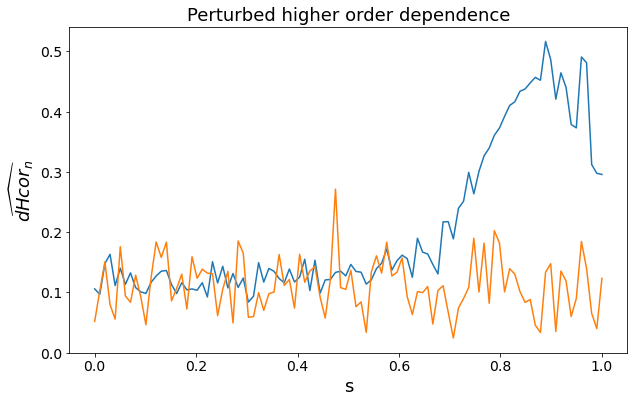

In [197]:
fig, ax = plt.subplots( figsize=(10, 6))
ax.plot(np.linspace(0,1,100), np.sqrt(dHSIC_cor3s))
ax.plot(np.linspace(0,1,100), g_corr3s)
ax.set_title("Perturbed higher order dependence", fontdict={'fontsize': 18})
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('s', fontdict={'fontsize': 18})
ax.set_ylabel(r'$\widehat{dHcor}_n$', fontdict={'fontsize': 18})
#plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/norm_ex3.png', format='png', bbox_inches='tight')
plt.show()

In [28]:
import pandas as pd


In [135]:
multi1 = pd.read_csv("/Users/saravallejomengod/MathsYear4/M4R/utils/multicor_df.csv", dtype=np.float64)

In [136]:
multi1

,multicor1,multicor1n,multicor2,multicor2n,multicor3,multicor3n
0,0.001245,0.000570,0.001864,0.000869,0.005783,0.002634
1,0.001977,0.000932,0.002141,0.001001,0.006839,0.003174
2,0.001504,0.000684,0.001294,0.000607,0.008515,0.003991
3,0.001757,0.000817,0.001362,0.000636,0.010967,0.005025
4,0.001914,0.000884,0.001412,0.000660,0.002645,0.001201
...,...,...,...,...,...,...
196,0.885249,0.416338,0.996978,0.471077,6.215133,0.638836
197,0.911815,0.422013,0.998322,0.463274,4.407275,0.654444
198,0.939867,0.434875,0.999216,0.457355,7.359026,0.665343
199,0.967643,0.444758,0.999810,0.469056,7.309933,0.653004


In [198]:
s = np.linspace(0,1,201)

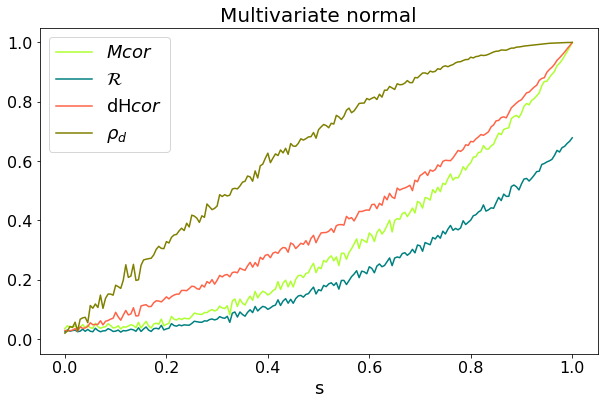

In [203]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Multivariate normal", fontsize=20)
plt.xlabel("s", fontsize=18)
plt.plot(s, np.sqrt(np.array(multi1['multicor1'])), color="greenyellow", label=r"$Mcor$")
plt.plot(s, np.sqrt(np.array(multi1['multicor1n'])), color="teal", label=r"$\mathcal{R}$")
plt.plot(s, np.sqrt(dHSIC_cor), color='tomato', label=r"dH$cor$")
plt.plot(s, g_corr, color="olive", label=r"$\rho_d$")
plt.ylim(top=1.05, bottom=-0.05)
plt.legend(fontsize=18)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)
plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/EX1.png', format='png', bbox_inches='tight')
plt.show()

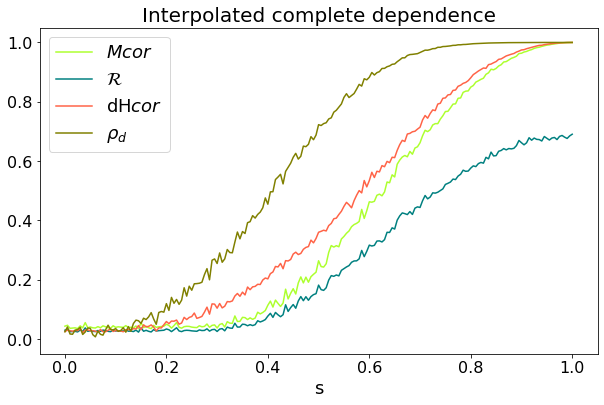

In [204]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Interpolated complete dependence", fontsize=20)
plt.xlabel("s", fontsize=18)
plt.plot(s, np.sqrt(np.array(multi1['multicor2'])), color="greenyellow", label=r"$Mcor$")
plt.plot(s, np.sqrt(np.array(multi1['multicor2n'])), color="teal", label=r"$\mathcal{R}$")
plt.plot(s, np.sqrt(dHSIC_cor2), color='tomato', label=r"dH$cor$")
plt.plot(s, g_corr2, color="olive", label=r"$\rho_d$")
plt.ylim(top=1.05, bottom=-0.05)
plt.legend(fontsize=18)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)
plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/EX2.png', format='png', bbox_inches='tight')
plt.show()

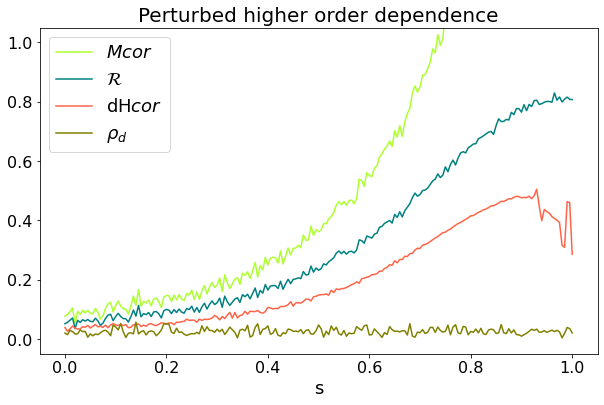

In [205]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Perturbed higher order dependence", fontsize=20)
plt.xlabel("s", fontsize=18)
plt.plot(s, np.sqrt(np.array(multi1['multicor3'])), color="greenyellow", label=r"$Mcor$")
plt.plot(s, np.sqrt(np.array(multi1['multicor3n'])), color="teal", label=r"$\mathcal{R}$")
plt.plot(s, np.sqrt(dHSIC_cor3), color='tomato', label=r"dH$cor$")
plt.plot(s, g_corr3, color="olive", label=r"$\rho_d$")
plt.ylim(top=1.05, bottom=-0.05)
plt.legend(fontsize=18)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.set_tick_params(labelsize=16)
plt.savefig('/Users/saravallejomengod/MathsYear4/M4R/utils/EX3.png', format='png', bbox_inches='tight')
plt.show()

In [188]:
dHSIC_cor3

[0.0014931450249470821,
 0.0006750996781173775,
 0.0011579892269207826,
 0.00188404355325733,
 0.001363101196636074,
 0.0011237142792326201,
 0.0011587948456889153,
 0.001725358464317116,
 0.0015436283305240437,
 0.002087799974377642,
 0.0013639430012490539,
 0.0018495435745313545,
 0.0023929682809644974,
 0.0016923826799995158,
 0.001816070812516954,
 0.001526351824386335,
 0.002160854163715705,
 0.0014344705953990293,
 0.002227852063614924,
 0.0027291737959730727,
 0.002205663076891519,
 0.0021302193533929057,
 0.002284921478349999,
 0.0020518936261295154,
 0.002380414281670137,
 0.0014341376512087849,
 0.001574307855479629,
 0.0023042685441862255,
 0.0024413923746939136,
 0.0025629740011929216,
 0.0017646414761138568,
 0.002184583992978833,
 0.001835482322789215,
 0.0024954507187008894,
 0.0026713961216088644,
 0.0022338851790107647,
 0.002021274923552287,
 0.002462327600605409,
 0.0029546983086736153,
 0.0028536852148289236,
 0.0026062713081508467,
 0.0029102859990927823,
 0.002980

In [67]:
np.array([x1,x2,x3]).shape

(3, 5000)

In [68]:
cov3 = np.cov(np.array([x1,x2,x3]))

In [69]:
cov3

array([[ 1.02984376, -0.01442579, -0.00143594],
       [-0.01442579,  0.9679692 ,  0.00119989],
       [-0.00143594,  0.00119989,  1.00231476]])

In [70]:
np.diag(cov3)

array([1.02984376, 0.9679692 , 1.00231476])

In [73]:
np.sqrt(1 -np.linalg.det(cov3)/(np.diag(cov3)[0]*np.diag(cov3)[1]*np.diag(cov3)[2]))

0.014566790388969008